### 运行前先装一个PyEMD库     是pip install pyemd   还是pip install PyEMD ，pip install EMD-signal  还试着装哪个成功

In [1]:
# 调用相关库
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import pandas as pd
from math import sqrt
from numpy import concatenate
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from scipy.io import savemat,loadmat
from keras.callbacks import LearningRateScheduler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from PyEMD import EMD,EEMD, Visualisation
from pandas import DataFrame
from pandas import concat
import keras.backend as K
import numpy
import os

In [2]:
# 转换成监督数据，将每个特征转换成21列数据，20->1，20组预测一组
def series_to_supervised(data, n_in=20, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]  #计算特征的数量
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    # 将20组输入数据依次向下移动20,19,...3,2,1行，将数据加入cols列表（技巧：(n_in, 0, -1)中的-1指倒序循环，步长为1）
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    # 将一组输出数据加入cols列表（技巧：其中i=0）
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # cols列表(list)中现在有21块经过下移后的数据(即：df(-20),df(-19),...df(-2),df(-1),df)，将四块数据按列 并排合并
    agg = pd.concat(cols, axis=1)
    # 给合并后的数据添加列名
    agg.columns = names
    # print(agg)
    # 删除NaN值列
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [3]:
values=pd.read_csv('train.csv').values[:5000,-1]
# values
# dates=df.index.values
n_features=1 #特征数量

In [4]:
values = values.astype('float32')
close = values

In [5]:
close=close.reshape(-1,1)
close.shape

(5000, 1)

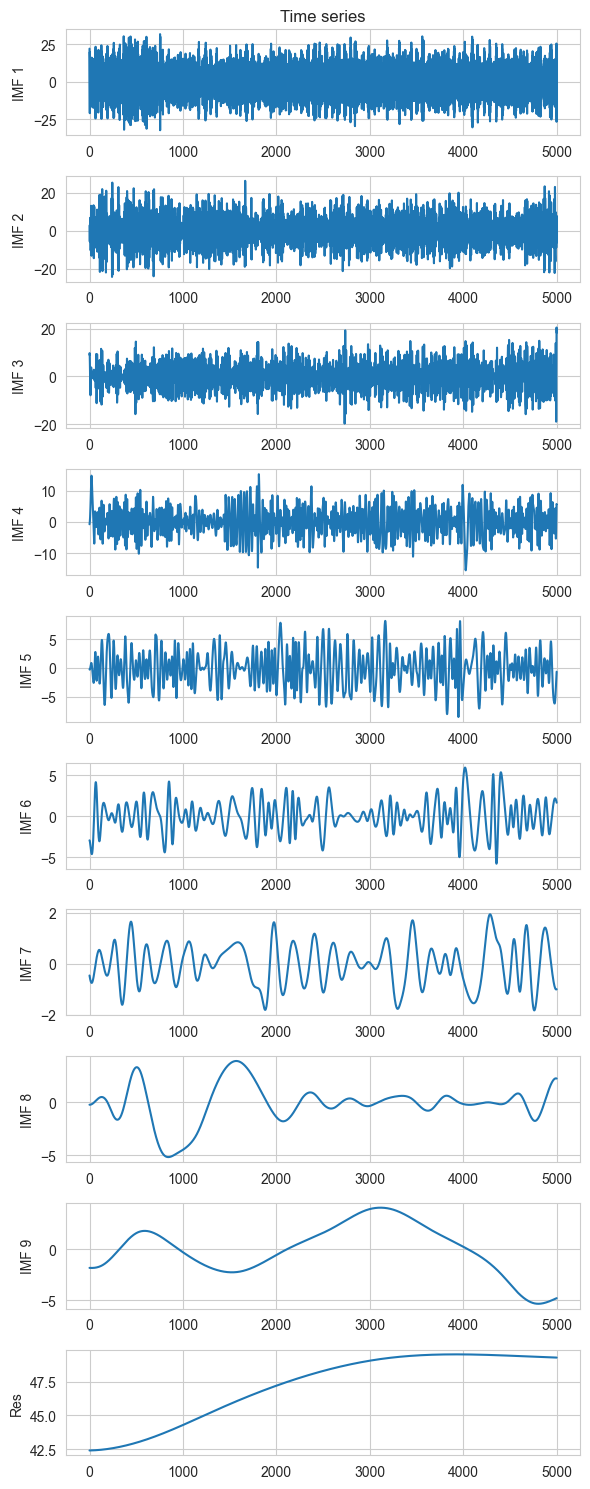

In [6]:
emd = EMD()   
emd.emd(close.reshape(-1))
imfs_close, res_close = emd.get_imfs_and_residue()

t = np.arange(0, 5000, 1)
vis = Visualisation()
vis.plot_imfs(imfs=imfs_close, residue=res_close, t=t, include_residue=True)
# vis.plot_instant_freq(t, imfs=imfs)
vis.show()

In [7]:
def implement_lstm(train_X, train_y):
    inputs=Input(shape=(train_X.shape[1], train_X.shape[2]))
    lstm=LSTM(256, activation='selu',return_sequences=False)(inputs)
    outputs = Dense(1)(lstm)
    model = Model(inputs=inputs, outputs=outputs)
#     model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.02),loss='mse')
    model.compile(loss='mse',optimizer='Adam')
    model.summary()#展示模型结构
    return model

In [8]:
svr = []
prediction_test = []
actual_test = []

i = 1
svr = []
prediction_test = []
actual_test = []

for imf in imfs_close:
    imf=imf.reshape(-1,1)
    imf=pd.DataFrame(imf)
    data_=imf.values
    data_ = data_.astype('float32')
    # 标准化
    scaler =StandardScaler()
    scaled = scaler.fit_transform(data_)
    
    # 构建成监督学习问题
    n_in=3
    n_out=1
    n_vars=1
# 构建成监督学习问题
    reframed = series_to_supervised(scaled, n_in, n_out)  # 预测时间步长为15 ，输出时间步1  ，即由t-15,t-14,....t-1预测t
    values_ = reframed.values 
    ratio=0.8 #训练集和测试集的划分比例
    N=int(len(values_) *ratio)
    train = values_[:N, :]
    test = values_[N:, :]
    # 把数据分为输入和输出
    train_X, train_y = train[:, :n_in*n_vars], train[:, n_in*n_vars:]
    test_X, test_y = test[:, :n_in*n_vars], test[:, n_in*n_vars:]
    # 把输入重塑成3D格式 [样例，时间步， 特征]
    train_X = train_X.reshape((train_X.shape[0], n_in, n_vars))
    test_X = test_X.reshape((test_X.shape[0],n_in, n_vars))
    
    #运行
    # 设计动态学习率下降模型
    def scheduler(epoch):
        # 每隔10个epoch，学习率减小为原来的1/2
        if epoch % 10 == 0 and epoch != 0:
            lr = K.get_value(tmp.optimizer.lr)
            K.set_value(tmp.optimizer.lr, lr * 0.5)
            print("lr changed to {}".format(lr * 0.5))
        return K.get_value(tmp.optimizer.lr)
    reduce_lr = LearningRateScheduler(scheduler)


    tmp = implement_lstm(train_X, train_y)
    history = tmp.fit(train_X, train_y, epochs=60, batch_size=30,callbacks=[reduce_lr], validation_data=(test_X, test_y), verbose=2,
                        shuffle=False)
    svr.append(tmp)
    
    
    # 作出预测
    yhat = tmp.predict(test_X)
    # 反向缩放预测值  测试集
    yhat = np.repeat(yhat,n_in*n_vars+n_out, axis=-1)
    inv_yhat=scaler.inverse_transform(np.reshape(yhat,(len(yhat),n_in*n_vars+n_out)))[:,0]
    prediction_test.append(inv_yhat)
    # 反向缩放实际值  测试集
    y = np.repeat(test_y,n_in*n_vars+n_out, axis=-1)
    inv_y=scaler.inverse_transform(np.reshape(y,(len(test_y),n_in*n_vars+n_out)))[:,0]
    actual_test.append(inv_y)

    





#####残差
imf=res_close.reshape(-1,1)
imf=pd.DataFrame(imf)
data_=imf.values
data_ = data_.astype('float32')
# 标准化
scaler =StandardScaler()
scaled = scaler.fit_transform(data_)
    
# 构建成监督学习问题
n_in=3
n_out=1
n_vars=1
# 构建成监督学习问题
reframed = series_to_supervised(scaled, n_in, n_out)  # 预测时间步长为15 ，输出时间步1  ，即由t-15,t-14,....t-1预测t
values_ = reframed.values 
ratio=0.8 #训练集和测试集的划分比例
N=int(len(values_) *ratio)
train = values_[:N, :]
test = values_[N:, :]
# 把数据分为输入和输出
train_X, train_y = train[:, :n_in*n_vars], train[:, n_in*n_vars:]
test_X, test_y = test[:, :n_in*n_vars], test[:, n_in*n_vars:]
# 把输入重塑成3D格式 [样例，时间步， 特征]
train_X = train_X.reshape((train_X.shape[0], n_in, n_vars))
test_X = test_X.reshape((test_X.shape[0],n_in, n_vars))
    
#运行
# 设计动态学习率下降模型
def scheduler(epoch):
    # 每隔10个epoch，学习率减小为原来的1/2
    if epoch % 10 == 0 and epoch != 0:
        lr = K.get_value(tmp.optimizer.lr)
        K.set_value(tmp.optimizer.lr, lr * 0.5)
        print("lr changed to {}".format(lr * 0.5))
    return K.get_value(tmp.optimizer.lr)
reduce_lr = LearningRateScheduler(scheduler)


tmp = implement_lstm(train_X, train_y)
history = tmp.fit(train_X, train_y, epochs=60, batch_size=30,callbacks=[reduce_lr], validation_data=(test_X, test_y), verbose=2,
                        shuffle=False)
svr.append(tmp)
    

    
    
    
# 作出预测
yhat = tmp.predict(test_X)
# 反向缩放预测值  测试集
yhat = np.repeat(yhat,n_in*n_vars+1, axis=-1)
inv_yhat=scaler.inverse_transform(np.reshape(yhat,(len(yhat),n_in*n_vars+1)))[:,0]
prediction_test.append(inv_yhat)
# 反向缩放实际值  测试集
y = np.repeat(test_y,n_in*n_vars+1, axis=-1)
inv_y=scaler.inverse_transform(np.reshape(y,(len(test_y),n_in*n_vars+1)))[:,0]
actual_test.append(inv_y)



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3, 1)]            0         
                                                                 
 lstm (LSTM)                 (None, 256)               264192    
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 264,449
Trainable params: 264,449
Non-trainable params: 0
_________________________________________________________________
Epoch 1/60
134/134 - 1s - loss: 0.8125 - val_loss: 0.7325 - lr: 0.0010 - 1s/epoch - 11ms/step
Epoch 2/60
134/134 - 1s - loss: 0.7785 - val_loss: 0.7173 - lr: 0.0010 - 758ms/epoch - 6ms/step
Epoch 3/60
134/134 - 1s - loss: 0.7625 - val_loss: 0.6936 - lr: 0.0010 - 758ms/epoch - 6ms/step
Epoch 4/60
134/134 - 1s - loss: 0

In [9]:
mean_pre_test = []                    

for i in range(0,len(prediction_test[0])):
    sum = 0
    for j in range(0,len(prediction_test)):
        sum = sum + prediction_test[j][i]
    
#     mean = sum/len(prediction_test) 
    mean_pre_test.append(sum)
        
mean_pre_test        

[61.81004536151886,
 39.908958703279495,
 39.235386818647385,
 39.45365513861179,
 62.548609897494316,
 76.9917569309473,
 50.442750096321106,
 73.0026670396328,
 54.11828815937042,
 43.4566371627152,
 47.344066858291626,
 46.66730758547783,
 45.09673121571541,
 55.642547473311424,
 48.06082181632519,
 33.94929926097393,
 34.444248385727406,
 41.85093428194523,
 31.660097539424896,
 23.864019140601158,
 43.718528270721436,
 51.77819474041462,
 60.07678300142288,
 61.00644715130329,
 56.18315503001213,
 62.969073474407196,
 33.2176918387413,
 64.62664429843426,
 38.37059451639652,
 25.348640874028206,
 13.361196786165237,
 29.021945774555206,
 48.785825699567795,
 29.624007642269135,
 63.212794452905655,
 53.1850391253829,
 42.00209780782461,
 46.83723225444555,
 50.873492769896984,
 40.83604100346565,
 27.39466854184866,
 19.323080092668533,
 28.239658303558826,
 28.410183146595955,
 55.13282323628664,
 34.9891722202301,
 56.9266107454896,
 46.245080187916756,
 54.049601178616285,
 59.

In [10]:
mean_actual_test = []

for i in range(0,len(actual_test[0])):
    sum = 0
    for j in range(0,len(actual_test)):
        sum = sum + actual_test[j][i]
    
#     mean = sum/len(actual_test)
    mean_actual_test.append(sum)
        
mean_actual_test    

[67.99999949336052,
 60.99999913573265,
 24.999997347593307,
 66.0000010728836,
 61.000001057982445,
 71.99999922513962,
 49.999999195337296,
 79.00000032782555,
 74.00000067055225,
 42.00000048801303,
 22.0000007301569,
 28.99999888241291,
 32.99999879300594,
 34.00000150501728,
 47.99999909102917,
 52.00000040233135,
 66.99999990314245,
 60.99999836087227,
 37.00000165402889,
 21.00000037252903,
 66.00000028312206,
 44.999999955296516,
 56.0000015348196,
 70.00000165402889,
 48.00000150501728,
 56.999999552965164,
 23.99999888241291,
 76.00000061094761,
 20.999999910593033,
 31.999999836087227,
 29.999999962747097,
 28.00000186264515,
 48.99999883770943,
 20.999999940395355,
 74.9999991953373,
 57.000001445412636,
 43.00000047683716,
 40.000001445412636,
 59.99999986588955,
 50.999999940395355,
 39.999998331069946,
 21.9999987334013,
 34.999999076128006,
 31.00000086426735,
 60.000000670552254,
 26.999998822808266,
 62.00000041723251,
 44.99999928474426,
 45.99999908357859,
 51.00000

In [11]:
# 计算RMSE
rmse = sqrt(mean_squared_error(mean_actual_test, mean_pre_test))
print('Test RMSE: %.7f' % rmse)
print('Test MAE: %.7f' % mean_absolute_error(mean_actual_test, mean_pre_test))
print('Test R2: %.7f' % r2_score(mean_actual_test, mean_pre_test))

Test RMSE: 9.4968959
Test MAE: 7.4272072
Test R2: 0.6337993


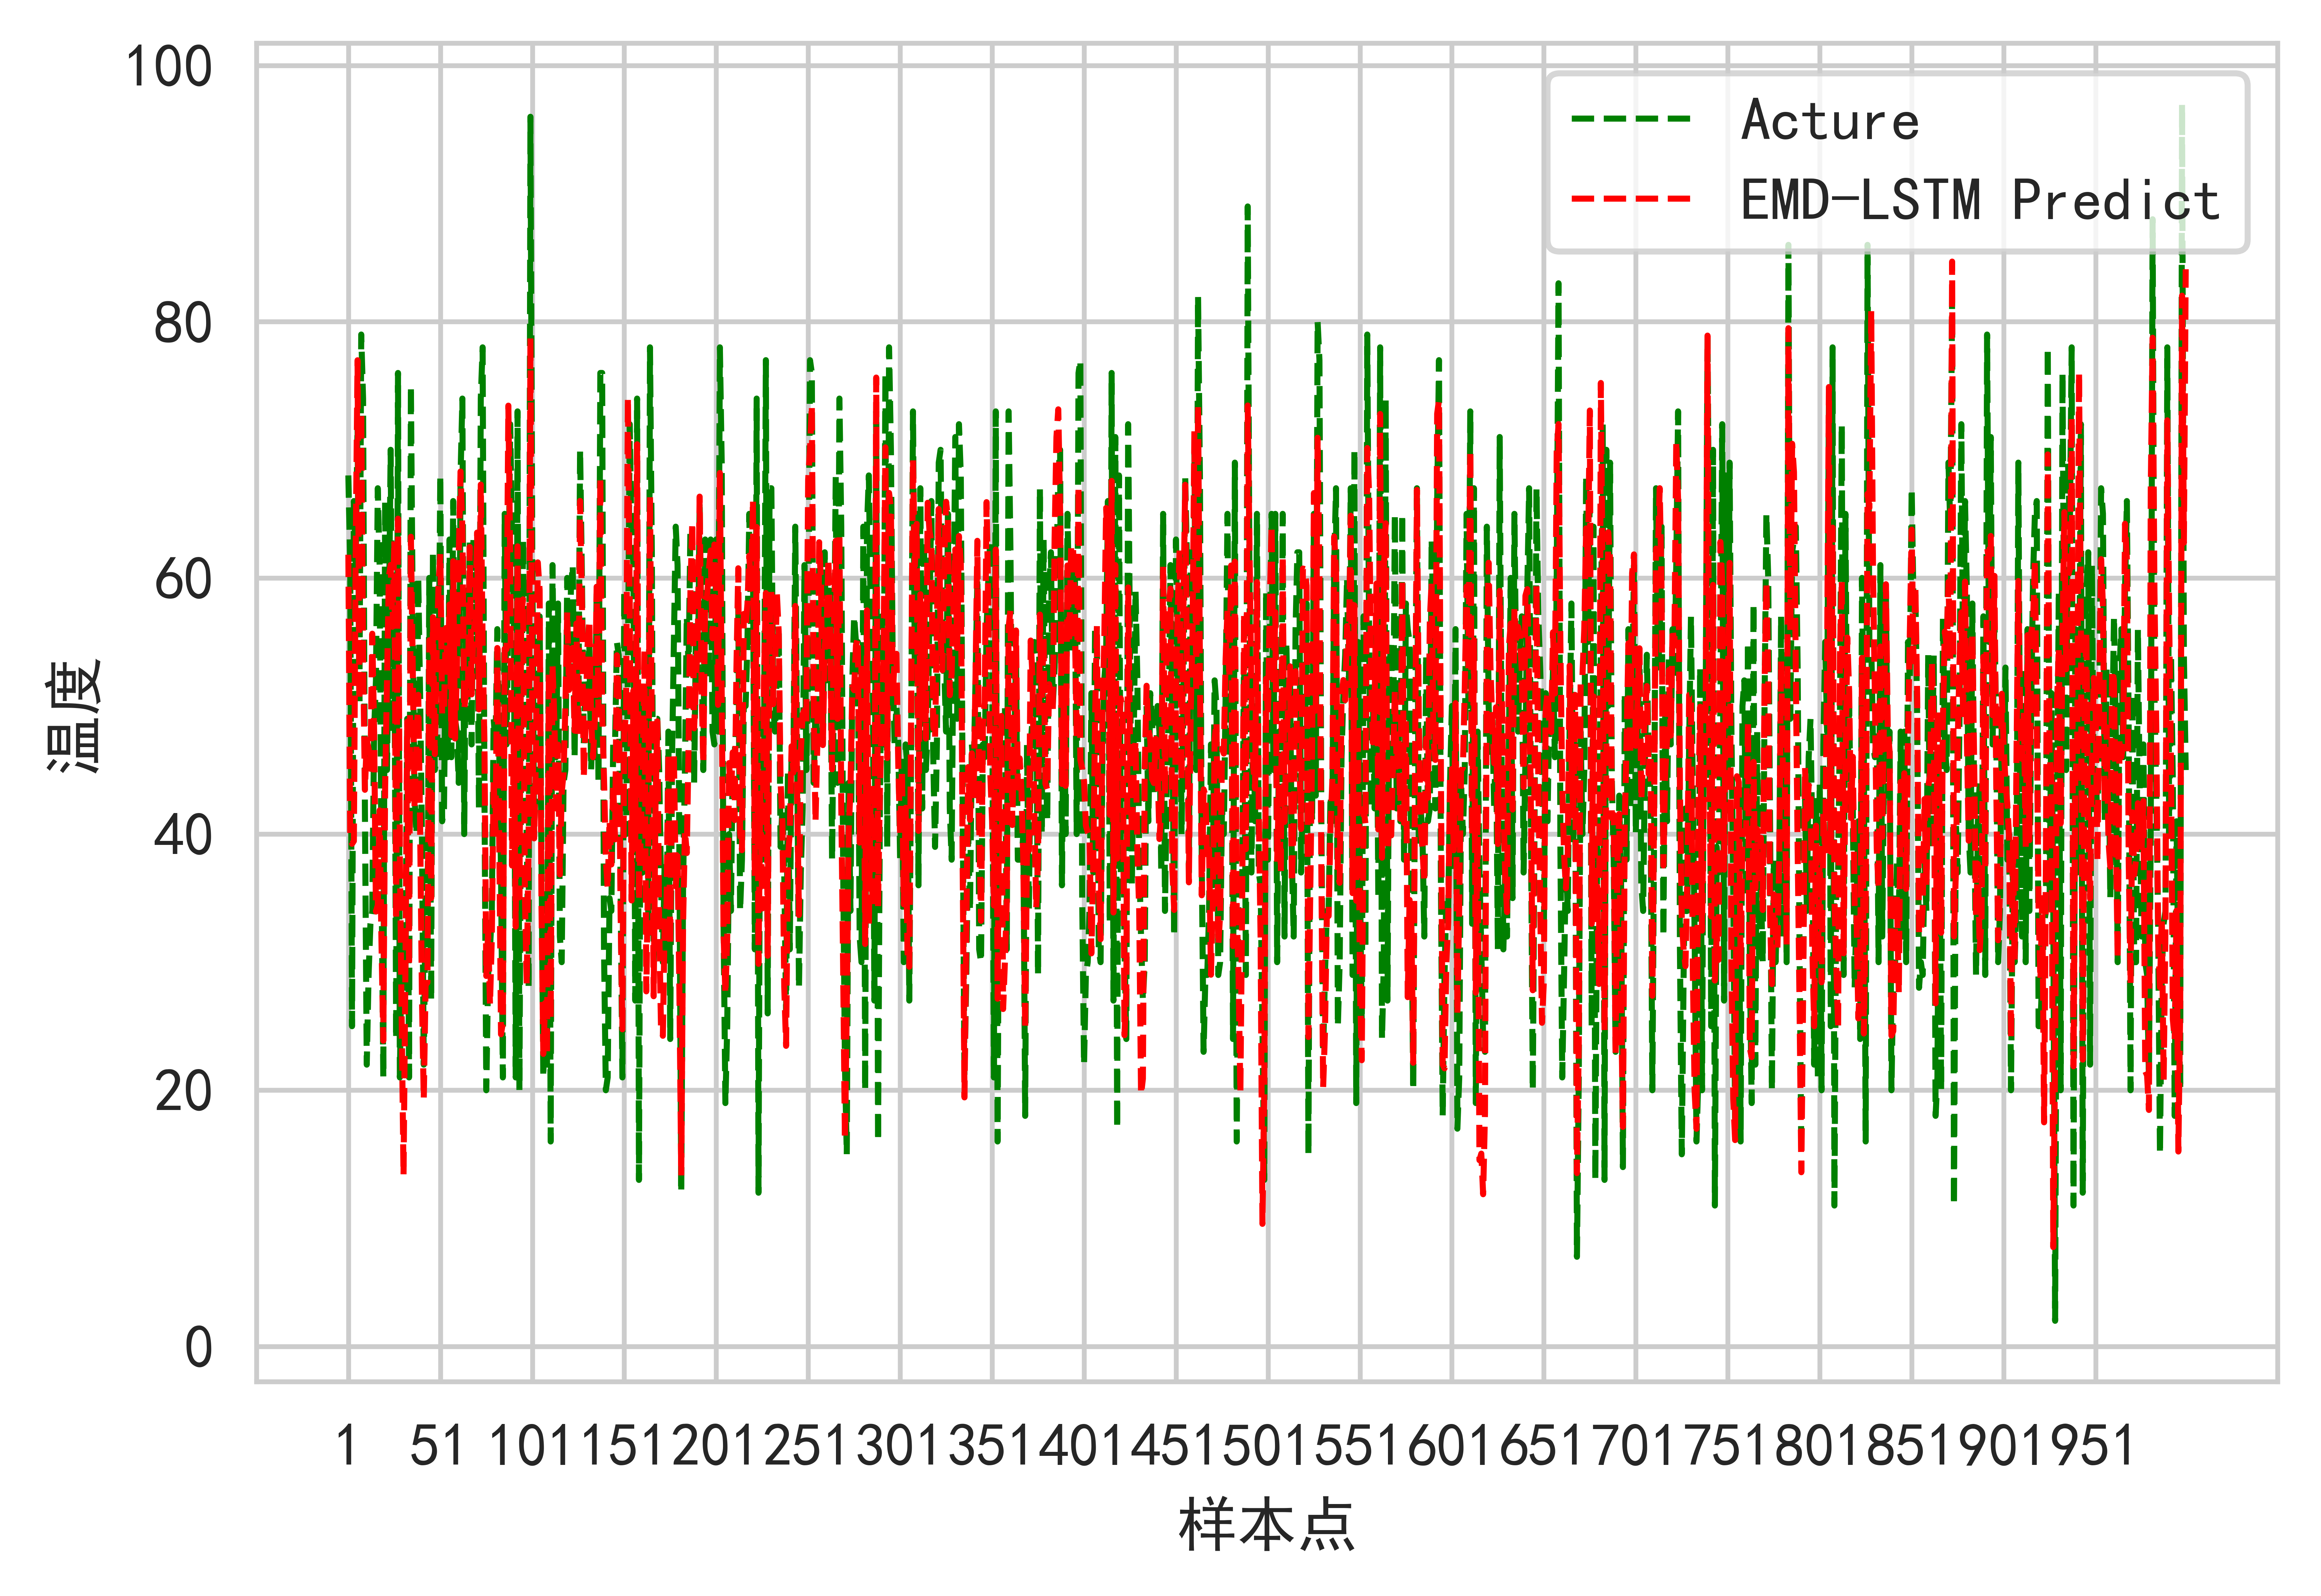

In [12]:
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
plt.rcParams['font.sans-serif']=['Simhei']  #解决画图中文不显示问题
plt.figure(figsize=(6,4),dpi=600)
x=range(1, len(mean_pre_test) + 1)
plt.xticks(x[::50])
plt.tick_params(labelsize=10)  #改变刻度字体大小
plt.plot(x, mean_actual_test, linestyle="--",color='g',linewidth=1, label='Acture')
plt.plot(x, mean_pre_test,  color='red',linestyle="--",linewidth=1,label='EMD-LSTM Predict')
plt.rcParams.update({'font.size': 10})  #改变图例里面的字体大小
plt.legend(loc='upper right')
plt.xlabel("样本点",fontsize=10)
plt.ylabel("温度",fontsize=10)
# plt.xlim(xmin=600,xmax=700)  #显示600-1000的值   局部放大有利于观察
# plt.savefig('台湾VMD-LSTM震级预测结果图.png')
plt.show()

In [13]:
#保存预测结果
savemat('结果/emd-lstm_result.mat',{'true':mean_actual_test,'pred':mean_pre_test})